# Orders & Requests in Video Game Texts
***
By [Alejandro Ciuba](https://alejandrociuba.github.io), alc307@pitt.edu
***
## Summary
In this notebook, I will be examining the following:
1. In what ways can orders and requests be realized in video game dialogue?
2. How can we capture these occurences?
3. What do they look like in use?
4. Are direct or indirect requests more common?
5. What are the most common form(s) orders and requests can take?

All of this is on a _"gotten-data-level"_, while I suspect many things found here may apply to video games as a whole, broad assumptions relating to this topic requires more data.

### Contents
1. [Introduction](#How-Are-Orders/Requests-Realized-in-Video-Game-Dialogue?)
2. [Matcher Expressions](#Matcher-Expressions)
3. [Regular Expressions](#Regular-Expressions)
4. [In-Use Samples](#Orders-&-Requests-In-Use)
5. [Graphs & Numbers](#Orders-&-Request-Numbers)
***
## Python Imports

In [14]:
# Necessary imports
import spacy
from spacy.matcher import Matcher

import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter
import re

import pickle as pkl

import notebook_funcs.notebook as nf
import specific_funcs.spec as sf

### Settings

In [15]:
# Settings
# I looked this up so everything is prettier
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Use display(dataframe) to show

%pprint

Pretty printing has been turned ON


### Useful Functions
All functions used in this notebook are defined in either `notebook_funcs/notebook.py` or `specific_funcs.specific.py`. Please consult these scripts to see exactly how the functions work behind-the-scenes.

### Data-Importing

In [16]:
# Bringing in the dataframes
FILEPATH = "../private/pickled_dfs/"

es_df = pd.read_pickle(FILEPATH + "elder_scrolls.pkl")
hk_df = pd.read_pickle(FILEPATH + "hollow_knight.pkl")
kotor_df = pd.read_pickle(FILEPATH + "kotor.pkl")
tl_df = pd.read_pickle(FILEPATH + "torchlight.pkl")

# All dfs stored in a simple list
datasets = [es_df, hk_df, kotor_df, tl_df]

### Document Set-Up

In [17]:
# Load the standard en_core_web transformer
nlp = spacy.load("en_core_web_trf")

In [18]:
# Load the pickled list
if True:
    with open('../private/pickled_docs/docs.pkl', 'rb') as src:
        docs = pkl.load(src)
        elder_scrolls_doc = docs[0]
        hollow_knight_doc = docs[1]
        kotor_doc = docs[2]
        torchlight_doc = docs[3]

### Dictionary

In [19]:
# Zip them together in one dictionary, first index is the dataframe, the second is the doc object generated by spaCy
data = {game: [df, doc] for (game, df, doc) in zip(["TES Books", "Hollow Knight", "KOTOR", "Torchlight II"], datasets, docs)}

***
## How Are Orders/Requests Realized in Video Game Dialogue?
This is a very broad topic. To approach this topic, let's first consider common phrases which indicate orders and requests.
- Direct Orders:
    1. _Mand. Form_ 
    2. _Don't/Do not/Do Mand. Form X._ 
    3. _I/we order/demand/force/command (that) you X._ (Performative Speech Act) 
- Indirect Orders:
    1. _You /need to/have to/ought to/must/should X._
    2. _Your objective/goal/quest/task is X._ 
    3. _I/we need/want/require/desire you Y._ 
    4. _Let's/Let us X._ 
- Direct Requests:
    1. _Please X._ 
    2. _I/we request (that you)/ask (of you) X._ (Performative Speech Act) 
- Indirect Requests:
    1. _I/we would like (that) you Y._ 
    2. _May/Would/Can/Could you X?_ Can you can be both an indirect request or direct question, requires context.
    3. _Is it possible for you to X?_ Same as 2.
    4. _Are you able to X?_

This is obviously not an exhastive list, but it does cover the most common forms that orders and requests can take. Troublingly, I might miss indirect speech acts which disguise themselves as assertions (e.g. _"Your homework isn't done!"_) because they are just too broad for me to capture. I will also miss sentences which require context such as tone and utterance-context (e.g. _"I'm not doing the report. You write it!_" vs. _"We'll make it big! You write it. I direct it. We'll be millionaires!"_).
 
**NOTE:** On top of these shortcomings, some speech acts I recognized had to be simplified due to complexity.

### Approach
A combination of regular expressions and _spaCy_'s _Matcher_, with its part of speech tagging ([est. 97% accuracy](https://spacy.io/usage/facts-figures#benchmarks)), will be used. While all of this can be done with only _spaCy_, the phrases which can be tagged through pure regular expressions will be more accurate overall.

There is some slight overlap between what the _Matcher_ expressions find and what the regex expressions find. That's okay, we can determine the exact type of order/request through context. Also note that I wasn't able to capture utterance context, so some false-positives will be present in these findings.
### Matcher Expressions
The ones I did through this were because either:
    
a) It was simply easier to think about using the Matcher's more dictionary-like style.
    
b) Morphological context was needed

In [20]:
# MATCHER EXPRESSIONS
matcher = Matcher(nlp.vocab)

DO1 = [{"IS_SENT_START": True, "MORPH": "VerbForm=Inf"},
    {"LEMMA": "not", "OP": "!"},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

DO3 = [{"LEMMA": {"IN": ["I", "we"]}}, 
    {"LEMMA": "be", "MORPH": {"IS_SUPERSET": ["Tense=Pres"]}, "OP": "?"}, 
    {"LOWER": {"REGEX": "^(order|force|demand|command)(ing)?$"}},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

IO2 = [{"LOWER": "your"},
    {"LEMMA": {"IN": ["objective", "goal", "quest", "task", "mission", "target"]}},
    {"LEMMA": "be", "MORPH": {"IS_SUPERSET": ["Tense=Pres"]}},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

IO3 = [{"LEMMA": {"IN": ["I", "we"]}},
    {"LEMMA": "be", "MORPH": {"IS_SUPERSET": ["Tense=Pres"]}, "OP":"?"}, 
    {"LOWER": {"REGEX": "^(need|want|require|desire|requir|desir)(ing)?$"}},
    {"LOWER": "that", "OP": "?"},
    {"LEMMA": "you"},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

DR2 = [{"LEMMA": {"IN": ["I", "we"]}},
    {"LEMMA": "be", "MORPH": {"IS_SUPERSET": ["Tense=Pres"]}, "OP":"?"}, 
    {"LOWER": {"REGEX": "^(request|ask)(ing)?$"}},
    {"LOWER": {"REGEX": "^that|of$"}, "OP": "?"},
    {"LEMMA": "you"},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

# Add them to the matcher and classify them
matcher.add("DO1", [DO1], greedy="LONGEST")
matcher.add("DO3", [DO3], greedy="LONGEST")
matcher.add("IO2", [IO2], greedy="LONGEST")
matcher.add("IO3", [IO3], greedy="LONGEST")
matcher.add("DR2", [DR2], greedy="LONGEST")

### Regular Expressions
These were the "copy and paste" ones, so-to-speak. These relied less on linguistical features, and most are divided into "chunks." Mainly, most contain a "Header" section consisting of either a simple `\b` word boundary, or a more complicated look-ahead section because they _specifically_ needed to start the beginning of a sentence/independent clause to correctly capture them. The next section is simply what I am looking for, the body. And lastly, the foot contains what would be the rest of the sentence. I want to capture this too, so it is not in a lookbehind section (not that I could do that anyway since both "looks" require a fixed length). The main thing that changes here is what punctuation I am looking for at the end.

In [21]:
# REGULAR EXPRESSIONS
DO2 = re.compile(r'(?<=[\.!\?,;:]\s)Do(?: not|n\'t(?: you)?) (?:[^\.!\?]+)?[\.!]', re.I)

IO1 = re.compile(r'\byou (?:really )?(?:(?:need to)|(?:have to)|(?:ought to)|must|should)(?! have [a-z]+ed\b)(?:[^\.!\?,]+)?[\.!,]', re.I)
IO4 = re.compile(r'(?<=[\.!\?,;:]\s)Let(?:\'s| us)(?:[^\.!\?,]+)?[\.!,]', re.I)

DR1 = re.compile(r'(?<=[\.!\?]\s)Please(?!, is)(?:[^\.!\?]+)?[\.!\?]+', re.I)

IR1 = re.compile(r'\b(?:I|we) would like(?: that)? you(?:[^\.!\?]+)[\.!]', re.I)
IR2 = re.compile(r'\b(?:May|Would|Can|Could) you(?! [a-z]+(?: that)? (?:I|we|you|y\'all|he|she|it|they))(?:[^\.!\?]+)?[\.!\?]+', re.I)
IR3 = re.compile(r'\bIs it possible for you to(?:[^\?]+)?\?', re.I)
IR4 = re.compile(r'(\bAre you able to(?:[^\?]+)?\?)', re.I)

# Toss them all into a nice little dict and call it a day :)
ord_req = {"DO2": DO2, "IO1": IO1, "IO4": IO4, "DR1": DR1, "IR1": IR1, "IR2": IR2, "IR3": IR3, "IR4": IR4}

### Orders & Requests In-Use
Now let's use these to examine some orders and requests. Let's start by looking at the orders and requests using the simple `re` regex, since a lot of context can still be observed by observing the rest of the Dataframe. I'll tackle this in a few stages, first I'll compile a list of orders and requests and observe what we see. Then, I'll try to graph the numbers of order and request types found per video game. Although, again, the regular expressions might produce false negatives and positives, so these numbers will be slightly off. I might try to formalize the precision and recall rates later, but probably not.

In [22]:
print("=============== ORDER AND REQUESTS FOR KOTOR ===============")
for regex in ord_req:
    print('\t' + regex)
    for text in nf.concordances(kotor_df, ord_req[regex], context_cols=['speaker'], num=1, highlight=False):
        print(text)

print("=============== ORDER AND REQUESTS FOR HOLLOW KNIGHT ===============")
for regex in ord_req:
    print('\t' + regex)
    for text in nf.concordances(hk_df, ord_req[regex], context_cols=['character'], num=1, highlight=False):
        print(text)

print("=============== ORDER AND REQUESTS FOR TORCHLIGHT II ===============")
for regex in ord_req:
    print('\t' + regex)
    for text in nf.concordances(tl_df, ord_req[regex], context_cols=['speaker'], num=1, highlight=False):
        print(text)

print("=============== ORDER AND REQUESTS FOR THE ELDER SCROLLS ===============")
for regex in ord_req:
    print('\t' + regex)
    for text in nf.concordances(es_df, ord_req[regex], context_cols=['author', 'title'], num=1, highlight=False):
        print(text)

=============== ORDER AND REQUESTS FOR KOTOR ===============
	DO2
Speaker: Elora | Concordance:
	...Don't insult us both!...
	IO1
Speaker: Elora | Concordance:
	...You must find Sunry innocent!...
	IO4
Speaker: Jolee | Concordance:
	...Let's not forget that he would have had to have been considerably older than the Sith woman....
	DR1
Speaker: Elora | Concordance:
	...Please, I must speak to him....
	IR1
	IR2
Speaker: Player | Concordance:
	...Can you tell me anything about Sunry?...
	IR3
Speaker: Bastila | Concordance:
	...Is it possible for you to keep in mind that we have more pressing business to attend to?...
	IR4
Speaker: Player | Concordance:
	...are you able to speak with the Sand People when I can't?...
=============== ORDER AND REQUESTS FOR HOLLOW KNIGHT ===============
	DO2
Character: Leg Eater | Concordance:
	...Don't try to trick me....
	IO1
Character: Confessor Jiji | Concordance:
	...you must need my help....
	IO4
Character: Iselda | Concordance:
	...let's see what's her

### Orders & Request Numbers

In [23]:
# Now for the hard part... graphing them. Hard because it'll be hard to make the graph look pretty :\
# Let's make a dataframe to keep track of everything
# Also... essentially quintuple for-loop. What? Sue me!

ordreq_df = pd.DataFrame({'speech_act_type':[], 'text':[], 'game': []})

for regex in ord_req:
    for game in data:
        for text in nf.concordances(data[game][0], ord_req[regex], num=-1, highlight=False):
            ordreq_df = ordreq_df.append({'speech_act_type': regex, 'text': text, 'game': game}, ignore_index=True)

# Now let's get the Matcher results
for game in data:
    doc = data[game][1]
    for (id, start, end) in matcher(doc):
        ordreq_df = ordreq_df.append({'speech_act_type': nlp.vocab.strings[id], 'text': doc[start:end].text, 'game': game}, ignore_index=True)

display(ordreq_df.head())

# And .pkl for the /sample_data directory
if False: ordreq_df.to_pickle('../sample_data/ordreq.pkl')

,speech_act_type,text,game
0,DO2,"...Don't worry, I'm not going to do what you t...",TES Books
1,DO2,...do not confuse Dunmer variety\nWith that fo...,TES Books
2,DO2,...Do not show them to anyone....,TES Books
3,DO2,...Do not attempt to read the documents in the...,TES Books
4,DO2,...don't tease....,TES Books


game,Hollow Knight,KOTOR,TES Books,Torchlight II
speech_act_type,,,,
DO1,182,40,243,211
DO2,39,264,477,2
DO3,0,0,2,0
DR1,11,177,146,9
DR2,0,0,2,1
IO1,36,637,558,43
IO2,0,0,1,1
IO3,1,0,3,1
IO4,11,187,95,1


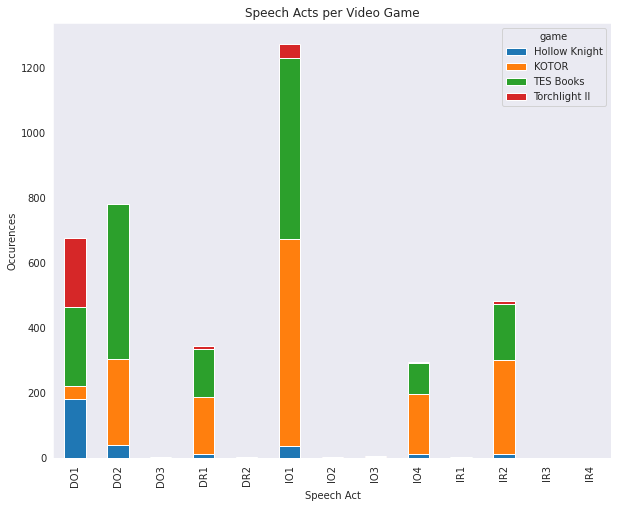

In [24]:
info = ordreq_df.groupby('speech_act_type').game.value_counts()
display(info.unstack(fill_value=0))
info.unstack().plot.bar(stacked=True, title='Speech Acts per Video Game', xlabel='Speech Act', ylabel='Occurences', figsize=(10, 8))
plt.show()

It is very interesting to see _"You /need to/have to/ought to/must/should X."_ be the most prevalent. The next two most prevalent are simply the positive and negative mandative forms, which make sense to be high on the list. Let's examine which verbs are the most popular with IO1, DO1, and DO2.

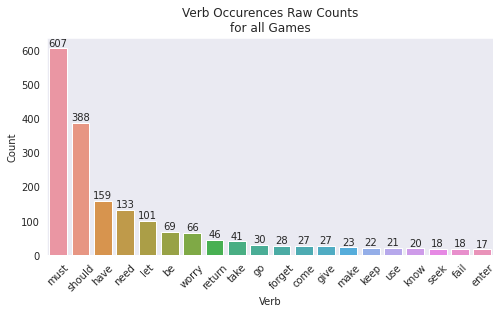

In [25]:
# Create new regular expressions that only capture the verbs in the phrases
# We can be a little more lenient here since we'll only run these with their
# Respective forms. I don't need linguistic information now either.
IO1_verbs = re.compile(r'you (?:really )?((?:need)|(?:have)|(?:ought to)|must|should)', re.I)
DO1_verbs = re.compile(r'^[a-z]+', re.I)
DO2_verbs = re.compile(r'Do(?: not|n\'t(?: you)?) ([a-z]+)' ,re.I)

verb_regexes = [IO1_verbs, DO1_verbs, DO2_verbs]

# Now let's get counts of all the verbs
counts = dict

filter = (ordreq_df['speech_act_type'] == 'IO1') | (ordreq_df['speech_act_type'] == 'DO1') | (ordreq_df['speech_act_type'] == 'DO2')
verb_counts = Counter([match[0].lower() for regex in verb_regexes for match in ordreq_df[filter].text.str.findall(regex) if len(match) > 0])

# For brevity, let's only get the top X verbs
X = 20
plt.figure(figsize=(8,4))
nf.barplot(x=[x for (x, y) in verb_counts.most_common(X)], y=[y for (x, y) in verb_counts.most_common(X)], 
            title='Verb Occurences Raw Counts\nfor all Games', xlabel="Verb", ylabel="Count", xtickrot=45)
plt.show()